# Connect to database

In [1]:
import os
import psycopg2 # PostgreSQL database adapter for Python
from dotenv import load_dotenv # Reads the key-value pair from .env file and adds them to environment variable

# Load environment variables from .env file
load_dotenv()

# Accessing credentials
db_host = os.getenv("DB_HOST")
db_name = os.getenv("DB_NAME")
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_port = os.getenv("DB_PORT")

In [2]:
# Connect to the database
conn = psycopg2.connect(
    host=db_host,
    dbname=db_name,
    user=db_user,
    password=db_password,
    port=db_port
)

# Retrieve relevant data from the database

In [3]:
query="""
    select TO_TIMESTAMP(year || '-' || month || '-' || day || ' ' || hour || ':' || min, 'YYYY-MM-DD HH24:MI') AT TIME ZONE 'UTC' as ts,
    gridimport_wh - gridexport_wh as net_load  
    from agg.t_msb1m  
    where site = 12
"""

In [4]:
import pandas as pd

df = pd.read_sql_query(query, conn)

C:\Users\elian\AppData\Local\Temp\ipykernel_99888\2309603890.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38036 entries, 0 to 38035
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ts        38036 non-null  datetime64[ns]
 1   net_load  38036 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 594.4 KB


In [6]:
df

,ts,net_load
0,2019-03-01 15:15:00,1011.03
1,2019-03-01 15:30:00,797.85
2,2019-03-01 15:45:00,512.28
3,2019-03-01 16:00:00,241.41
4,2019-03-01 16:15:00,137.48
...,...,...
38031,2020-03-31 22:45:00,8.49
38032,2020-03-31 23:00:00,8.70
38033,2020-03-31 23:15:00,8.67
38034,2020-03-31 23:30:00,8.52


In [7]:
# Convert 'ts' to datetime and set as index
df['ts'] = pd.to_datetime(df['ts'])
df.set_index('ts', inplace=True)

df

,net_load
ts,
2019-03-01 15:15:00,1011.03
2019-03-01 15:30:00,797.85
2019-03-01 15:45:00,512.28
2019-03-01 16:00:00,241.41
2019-03-01 16:15:00,137.48
...,...
2020-03-31 22:45:00,8.49
2020-03-31 23:00:00,8.70
2020-03-31 23:15:00,8.67


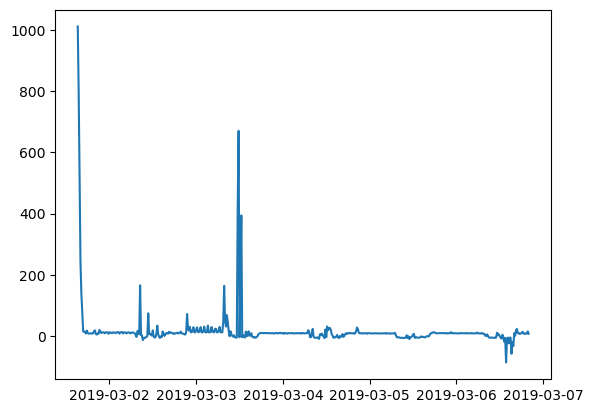

In [8]:
import matplotlib.pyplot as plt
plt.plot(df.index[0:500], df.net_load[0:500])
plt.show()

# Normalise net load

In [9]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Normalise the 'net_load' values using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df['net_load_norm'] = scaler.fit_transform(df[['net_load']])

df

,net_load,net_load_norm
ts,,
2019-03-01 15:15:00,1011.03,0.915236
2019-03-01 15:30:00,797.85,0.806956
2019-03-01 15:45:00,512.28,0.661906
2019-03-01 16:00:00,241.41,0.524322
2019-03-01 16:15:00,137.48,0.471533
...,...,...
2020-03-31 22:45:00,8.49,0.406015
2020-03-31 23:00:00,8.70,0.406122
2020-03-31 23:15:00,8.67,0.406106


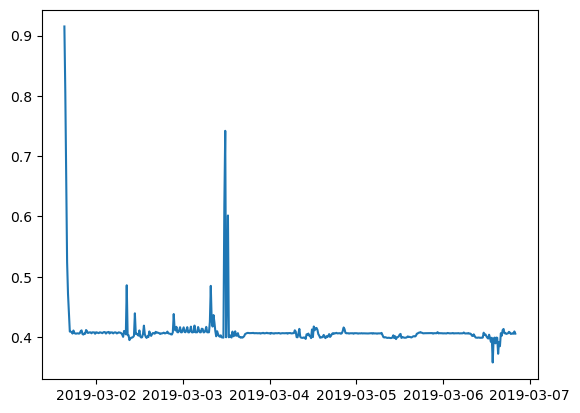

In [10]:
import matplotlib.pyplot as plt
plt.plot(df.index[0:500], df.net_load_norm[0:500])
plt.show()

# Build LSTM model

### Create train and test where the last 24 hours are used as the test

In [38]:
net_load_norm = df['net_load_norm']

# Train 4 weeks
# Test 1 day


train = net_load_norm[:4*24*7*4]
test = net_load_norm[4*24*7*4:4*24*7*4+4*24]

<Axes: xlabel='ts'>

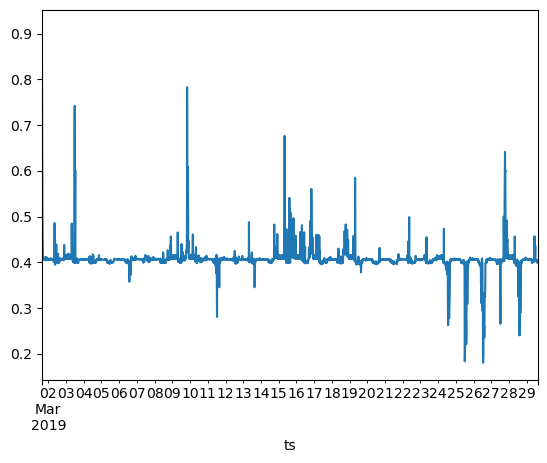

In [39]:
train.plot()

<Axes: xlabel='ts'>

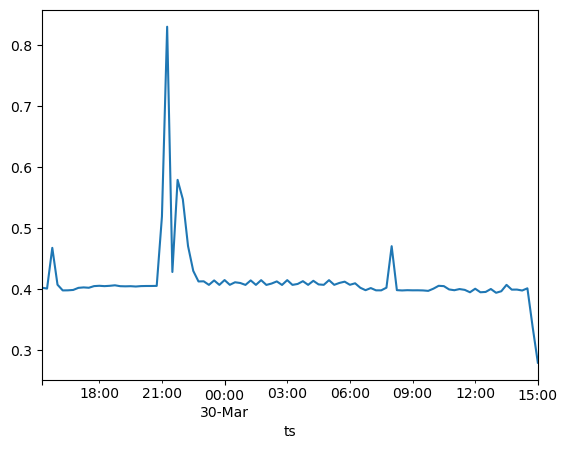

In [40]:
test.plot()

### Transform time series data into a suitable 3D tensor / matrix suitable for training the LSTM model.

In [1]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

n_inputs = 4*24*1
n_features = 1

# n_inputs dictates how many of the past time stamps should be considered for the prediction i.e., in this case we are considering the past 1 days.
# n_features dictates how many time series we are considering i.e., in this case only 1 (net load norm) but can be 2 if we consider solar irradiance for example. 

generator = TimeseriesGenerator(train, train, length=n_inputs, batch_size=5)

NameError: name 'train' is not defined

In [42]:
X, y = generator[0]
print(f'Given the array X: \n {X.flatten()}\n')
print(f'Predict this y value: \n {y}')

Given the array X: 
 [0.91523642 0.80695561 0.66190566 0.52432229 0.47153299 0.44011235
 0.4090168  0.40893045 0.40798062 0.40567969 0.41074376 0.4069292
 0.40568985 0.40556794 0.4060454  0.40599969 0.40557302 0.40613683
 0.40953997 0.41100281 0.40488732 0.40406955 0.40579651 0.40534953
 0.41154122 0.40980409 0.4066346  0.40711713 0.40773681 0.40768094
 0.40612667 0.40775713 0.40770633 0.40763014 0.40541048 0.40776221
 0.40758951 0.40686825 0.40642635 0.40770126 0.40752856 0.40708158
 0.40631968 0.40767078 0.40823458 0.40790951 0.40570508 0.40762507
 0.40791967 0.40840728 0.40584223 0.40763522 0.4075184  0.40759967
 0.40593365 0.40725428 0.40772665 0.4075184  0.40593873 0.40669047
 0.40770633 0.40742189 0.40708158 0.40611651 0.40391209 0.40020927
 0.4099971  0.40967711 0.40447589 0.4858211  0.403074   0.40296733
 0.39485567 0.39739533 0.39899023 0.39900547 0.39999594 0.40205306
 0.43928951 0.40504985 0.40552223 0.4036378  0.40230702 0.41088598
 0.40078831 0.39915785 0.39960483 0.405313

### Build LSTM architecture

In [43]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [44]:
model = Sequential()
model.add(LSTM(10, activation='relu', input_shape=(n_inputs, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')

c:\Users\elian\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [45]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491 (1.92 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

### Fit the model

In [46]:
model.fit(generator, epochs=20)

Epoch 1/20


  17/2592 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 0.5535  

c:\Users\elian\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2592/2592 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.0661
Epoch 2/20
2592/2592 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - loss: 0.0089
Epoch 3/20
2592/2592 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - loss: 0.0080
Epoch 4/20
2592/2592 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - loss: 0.0075
Epoch 5/20
2592/2592 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - loss: 0.0083
Epoch 6/20
2592/2592 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - loss: 0.0082
Epoch 7/20
2592/2592 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - loss: 0.0075
Epoch 8/20
2592/2592 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - loss: 0.0081
Epoch 9/20
2592/2592 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - loss: 0.0079
Epoch 10/20
2592/2592 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - loss: 0.0088
Epoch 11/20
2592/2592 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - loss: 0.0081
Epoch 12/20
2592/2592 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - loss: 0.0079
Epoch 13/20
2592/2592 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - loss: 0.0078
Epoch 14/20
2592/2592 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - loss: 0.0084
Epoch 15/20
2592/2592 

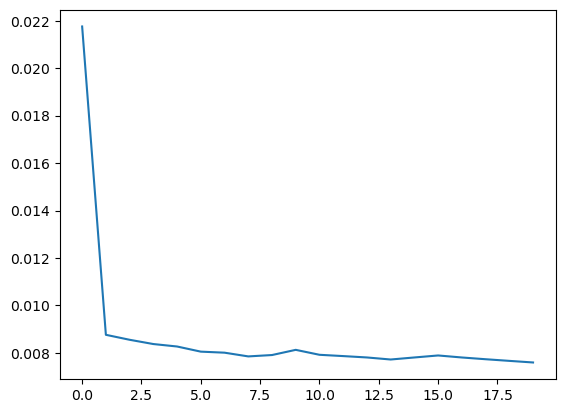

In [48]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

### Make forecast on the testing set

In [51]:
test_prediction = []

first_eval_batch = train[-n_inputs:]
current_batch = first_eval_batch.reshape((1, n_inputs, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_prediction.append(current_batch)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)



AttributeError: 'Series' object has no attribute 'reshape'

In [53]:
first_eval_batch

ts
2019-03-02 15:15:00    0.401840
2019-03-02 15:30:00    0.404710
2019-03-02 15:45:00    0.406579
2019-03-02 16:00:00    0.406289
2019-03-02 16:15:00    0.405441
                         ...   
2019-03-29 14:00:00    0.404395
2019-03-29 14:15:00    0.398884
2019-03-29 14:30:00    0.400468
2019-03-29 14:45:00    0.402073
2019-03-29 15:00:00    0.401225
Name: net_load_norm, Length: 2592, dtype: float64